In [1]:
import pandas as pd
import seaborn as sns
import rf
import os
import pygmt
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
shubhdf = pd.read_csv(
    "../agrawal.txt",
    sep="\s+",
    names=("Network", "Station", "Latitude", "Longitude", "nRF", "TPsb", "Estimated Depth"),
    skiprows=2
)
shubhdf.set_index("Station", inplace=True)
shubhdf.drop(labels=["nRF", "Estimated Depth"], axis=1, inplace=True)

In [3]:
all_analysis_dir = "rf_data/processed/"
latest_run = max(
    [
        os.path.join(all_analysis_dir, d)
        for d in os.listdir(all_analysis_dir)
        if os.path.isdir(os.path.join(all_analysis_dir, d))
    ],
    key=os.path.getmtime,
)
delaysdf = pd.read_csv(
    os.path.join(latest_run, "delays.txt"),
    sep="\s+",
    names=("Network", "Station", "Longitude", "Latitude", "TPsb"),
)
delaysdf.set_index("Station", inplace=True)

In [4]:
df = delaysdf.join(shubhdf, how="inner", lsuffix=None, rsuffix="_shubh")
df.Network.fillna(df.Network_shubh, inplace=True)
df.Longitude.fillna(df.Longitude_shubh, inplace=True)
df.Latitude.fillna(df.Latitude_shubh, inplace=True)
df.drop(labels=["Network_shubh", "Latitude_shubh", "Longitude_shubh"], axis=1, inplace=True)
df.rename(columns={"TPsb": "TPsb_me"}, inplace=True)
df["TPsb_diff"] = (df["TPsb_me"] - df["TPsb_shubh"]).abs()
df = df[~df.index.duplicated()]
df.head()

,Network,Longitude,Latitude,TPsb_me,TPsb_shubh,TPsb_diff
Station,,,,,,
AEB01,5G,136.8030,-28.7625,0.64,0.59,0.05
AEB02,5G,135.3248,-25.9877,1.14,1.13,0.01
AEB04,5G,135.5654,-29.0204,0.32,0.34,0.02
AEB05,5G,137.1455,-25.9918,1.36,1.28,0.08
AEB07,5G,139.4905,-26.3257,1.02,1.09,0.07


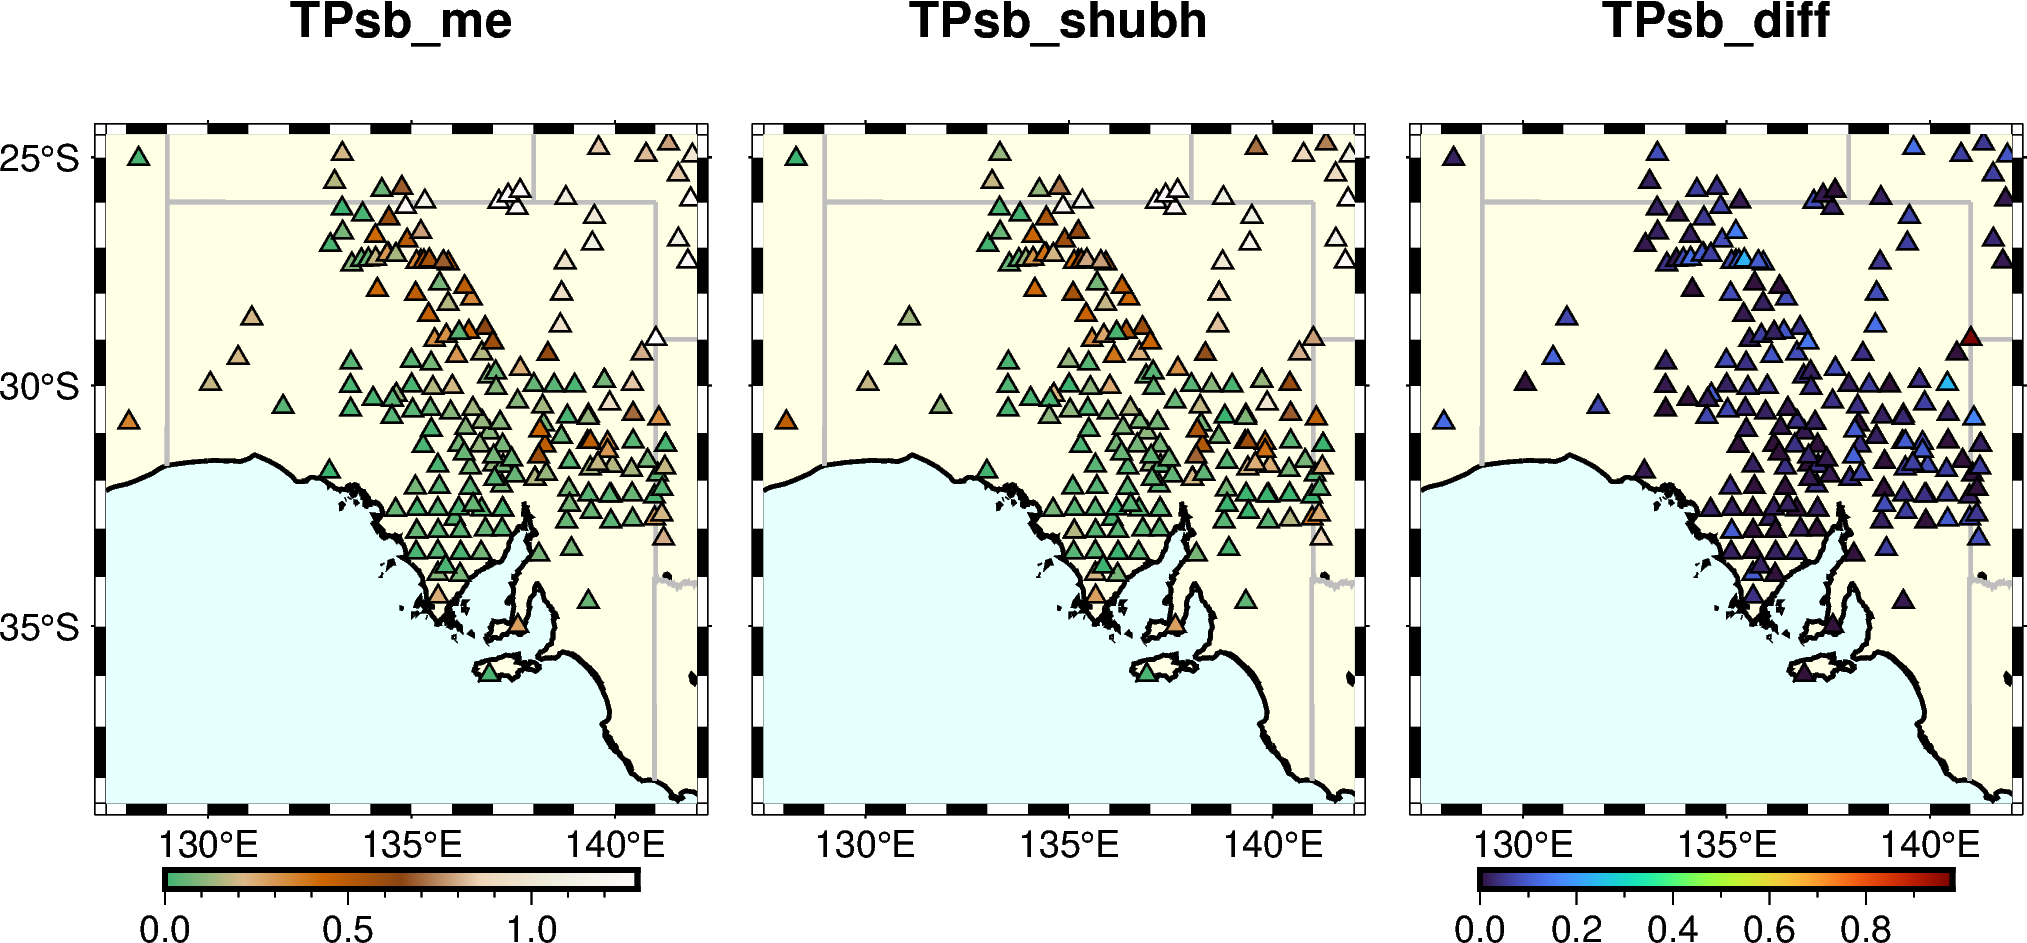

In [5]:
fig = pygmt.Figure()
pygmt.config(FONT_TITLE="12")
lons = df["Longitude"]
lats = df["Latitude"]
ln_min, ln_max = (127.5, 142)
lt_min, lt_max = (-38.5, -24.5)
region = [ln_min, ln_max, lt_min, lt_max]
_width = 5
projection = f"M12/11/{_width}c"
cbar_position = "JBC"

with fig.subplot(
    nrows=1, ncols=3, subsize=(f"{_width}c", "6c"), sharey="l", frame="WSne",
):
    for j, d in enumerate(["TPsb_me", "TPsb_shubh", "TPsb_diff"]):
        with fig.set_panel(panel=j):
            frame = f"+t{d}"
            fig.basemap(region=region, frame=frame, projection=projection)
            fig.coast(
                shorelines=1,
                land="#ffffe6",
                water="#e6ffff",
                borders="2/1p,grey",
                projection=projection,
                region=region,
            )
            if d in ["TPsb_me", "TPsb_shubh"]:
                _mn = (df[["TPsb_me", "TPsb_shubh"]].min()).min()
                _mx = (df[["TPsb_me", "TPsb_shubh"]].max()).min()
            else:
                _mn = df["TPsb_diff"].min()
                _mx = df["TPsb_diff"].max()
            pygmt.makecpt(cmap="turbo" if d == "TPsb_diff" else "dem3", series=[_mn, _mx])
            fig.plot(
                x=lons,
                y=lats,
                projection=projection,
                region=region,
                style=f"tc",
                pen="0.5p",
                fill=df[d],
                cmap=True,
                size=np.full_like(lons, 0.2),
            )
            if d in ["TPsb_me", "TPsb_diff"]:
                fig.colorbar(frame="af", position=f"{cbar_position}")
fig.show()


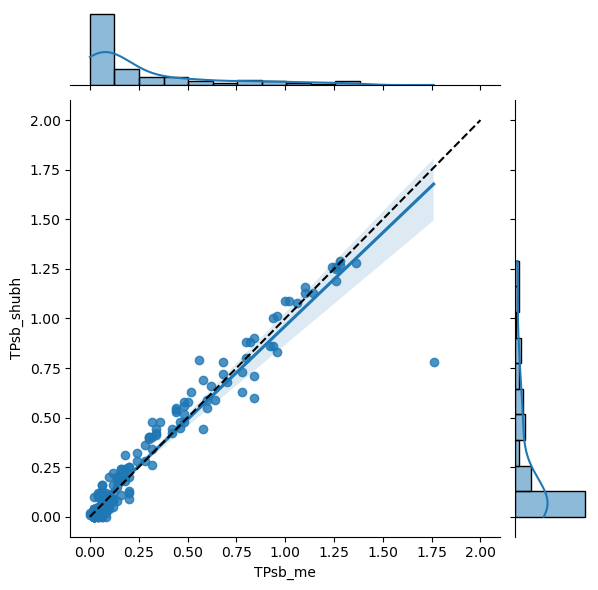

In [6]:
g = sns.jointplot(data=df, x="TPsb_me", y="TPsb_shubh", kind="reg")
g.ax_joint.plot([0, 2], [0, 2], "k--")

In [7]:
s = df["TPsb_diff"].std()
df[df["TPsb_diff"] > 2 * s]

,Network,Longitude,Latitude,TPsb_me,TPsb_shubh,TPsb_diff
Station,,,,,,
CU01,1F,140.99979,-28.99593,1.76,0.78,0.98
CU04,1F,141.07238,-30.69608,0.32,0.48,0.16
CU10,1F,140.42280,-29.96164,0.84,0.60,0.24
MAL54,3G,135.43654,-27.28651,0.56,0.79,0.23


In [8]:
def delay_to_depth_shubh(tpsb: npt.ArrayLike) -> np.ndarray:
    depth = np.zeros_like(tpsb)
    depth[tpsb < 0.58] = 366 * tpsb[tpsb < 0.58]
    depth[tpsb >= 0.58] = 3206.9 * tpsb[tpsb >= 0.58] - 166.2
    return depth

In [9]:
df["DepthPrediction"] = delay_to_depth_shubh(df["TPsb_shubh"])

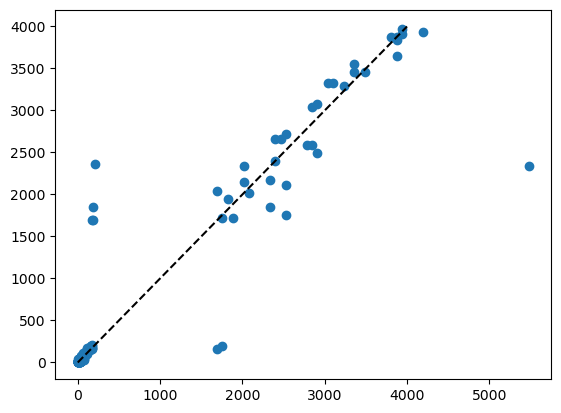

In [10]:
ax = plt.axes()
ax.scatter(delay_to_depth_shubh(df["TPsb_me"]), df["DepthPrediction"])
ax.plot([0, 4000], [0, 4000], "k--")

Compare with OZSEEBASE

In [11]:
grid = pygmt.xyz2grd(data=f"{os.environ['HOME']}/data//OZSEEBASE2021.xyz", region=region, spacing=0.01)
grid *= -1
grid = pygmt.grdclip(grid=grid, above=(7500, 7500), below=(0, 0))

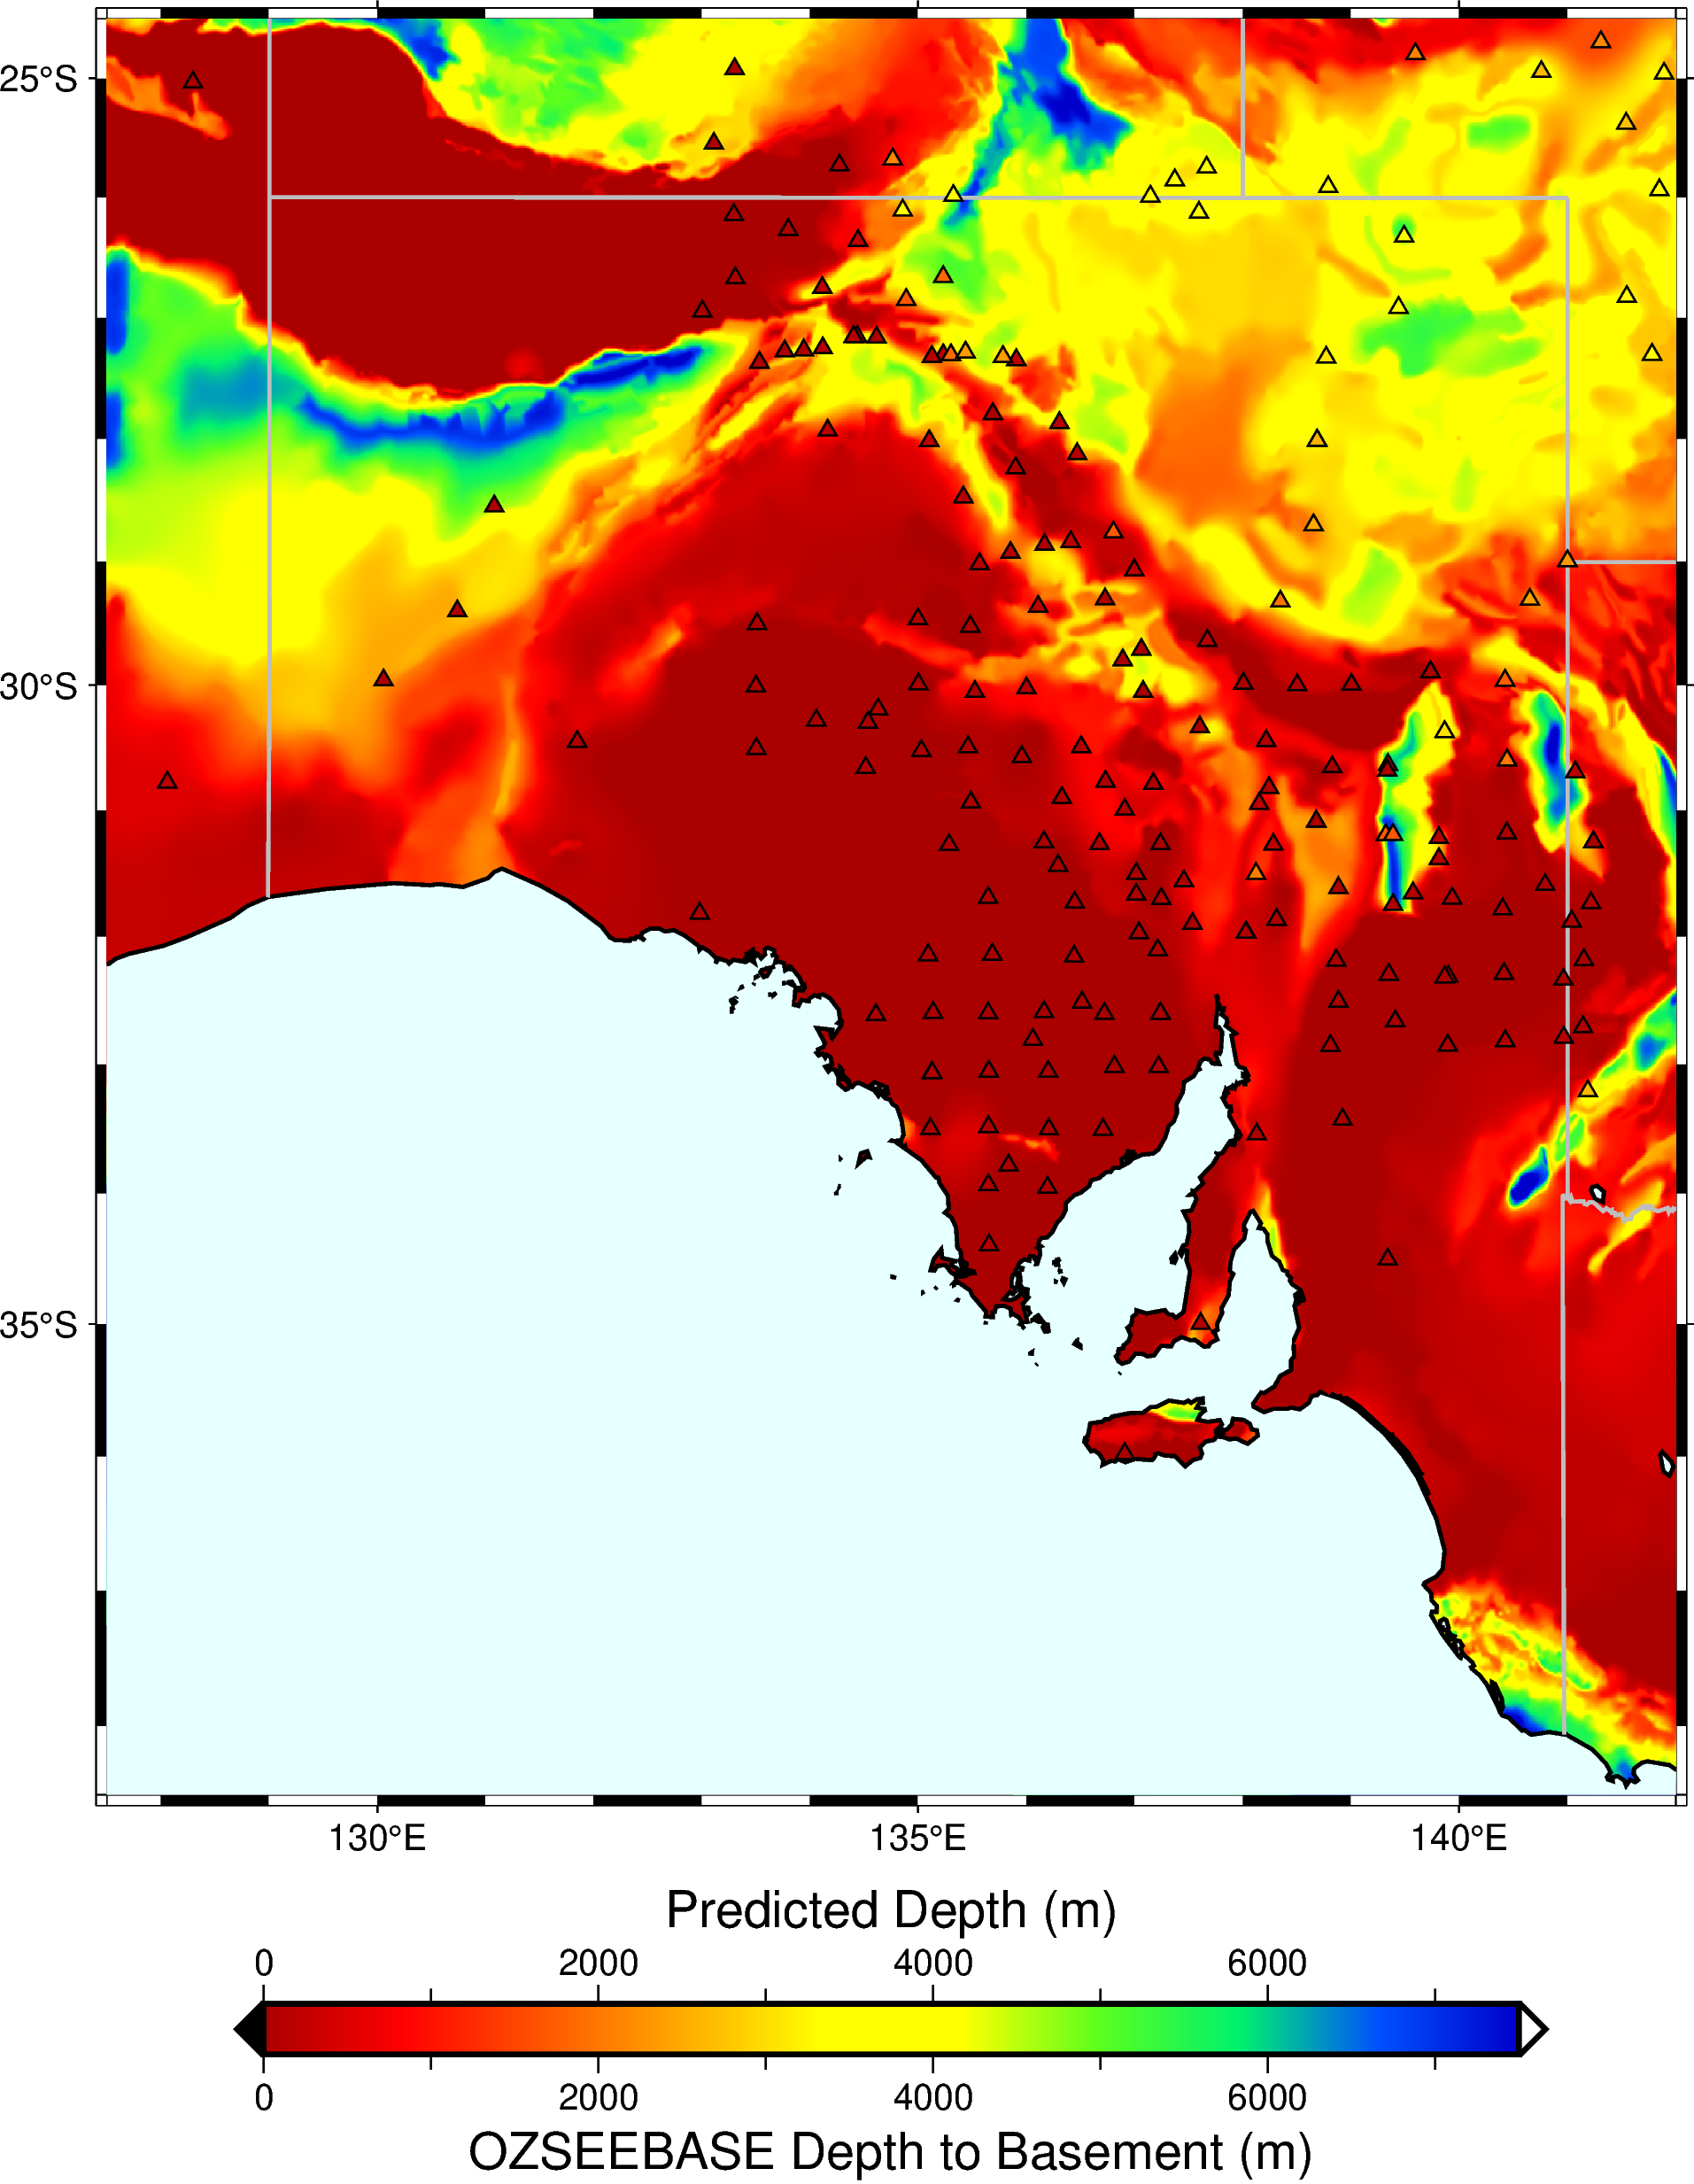

In [12]:
cmap = "gmt/seis"
projection = f"M12/11/15"
fig = pygmt.Figure()
fig.basemap(region=region, projection=projection, frame=True)
fig.grdimage(grid=grid, nan_transparent=True, cmap=cmap)
fig.coast(shorelines=1, borders="2/1p,grey", water="#e6ffff")
cbar_position = "JBC+o0/2"
fig.colorbar(frame="af+lOZSEEBASE Depth to Basement (m)", position=cbar_position)
pygmt.makecpt(cmap=cmap, series=[0, 7500])
fig.plot(
    x=lons,
    y=lats,
    projection=projection,
    region=region,
    style=f"tc",
    pen="0.5p",
    fill=df["DepthPrediction"],
    cmap=True,
    size=np.full_like(lons, 0.2),
)
fig.colorbar(frame="af+lPredicted Depth (m)", position=f"{cbar_position}+e+mal")
fig.show()


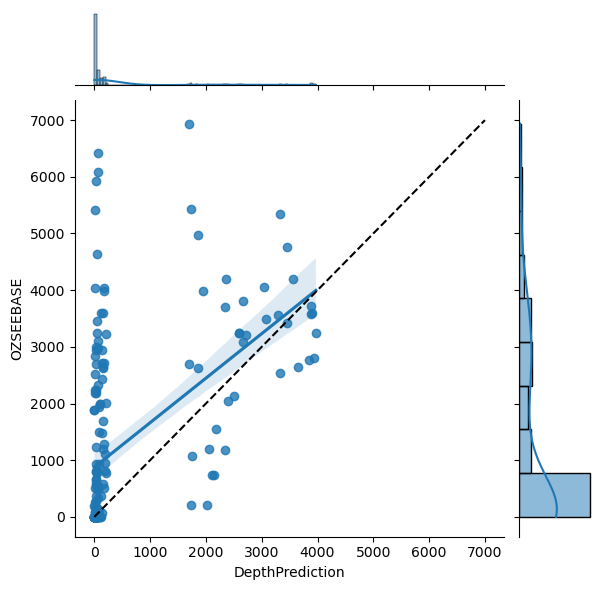

In [13]:
from xarray import DataArray
df["OZSEEBASE"] = grid.sel(y=DataArray(lats.values, dims="z"), x=DataArray(lons.values, dims="z"), method="nearest")
g = sns.jointplot(df, x="DepthPrediction", y="OZSEEBASE", kind="reg")
g.ax_joint.plot([0, 7000], [0, 7000], "k--")

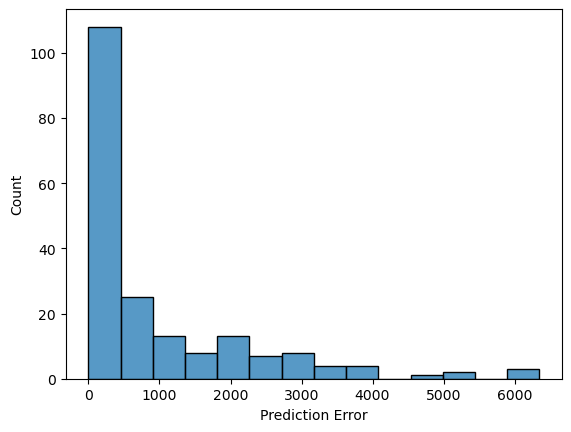

In [14]:
df["Prediction Error"] = (df["DepthPrediction"] - df["OZSEEBASE"]).abs()
sns.histplot(data=df, x="Prediction Error")

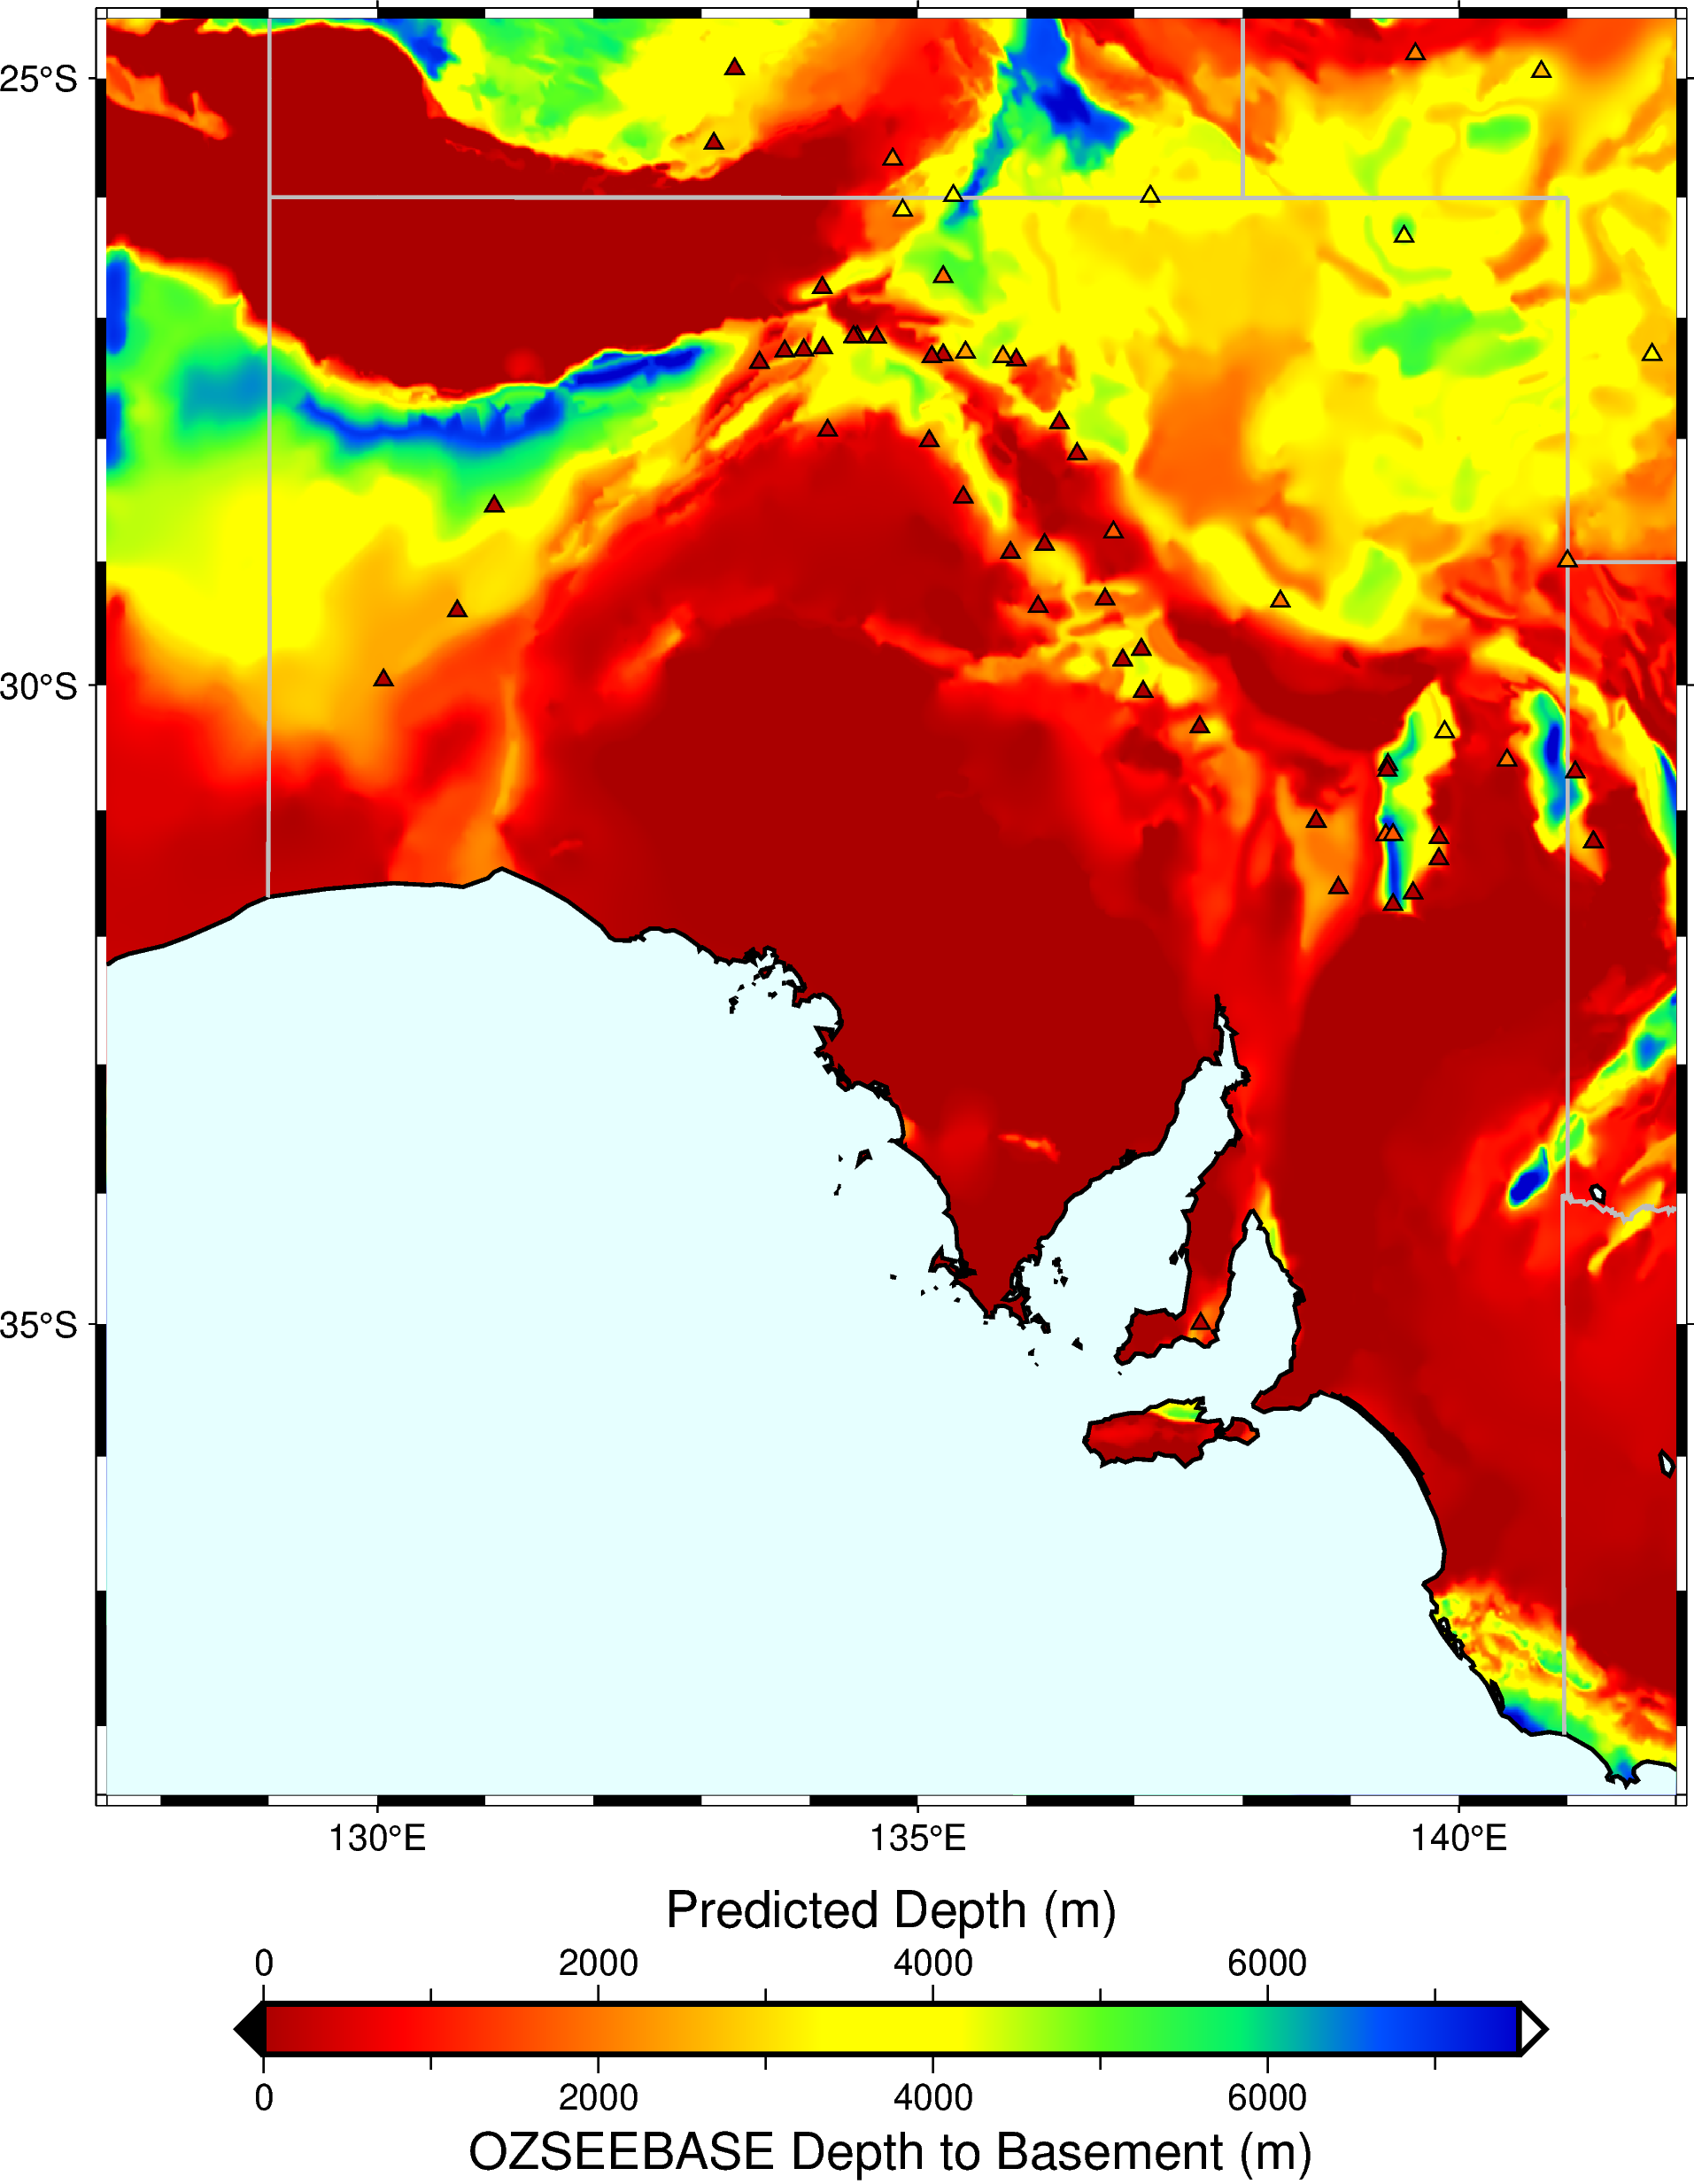

In [15]:
worst_stations = df["Prediction Error"] > 1000
cmap = "gmt/seis"
projection = f"M12/11/15"
fig = pygmt.Figure()
fig.basemap(region=region, projection=projection, frame=True)
fig.grdimage(grid=grid, nan_transparent=True, cmap=cmap)
fig.coast(shorelines=1, borders="2/1p,grey", water="#e6ffff")
cbar_position = "JBC+o0/2"
fig.colorbar(frame="af+lOZSEEBASE Depth to Basement (m)", position=cbar_position)
pygmt.makecpt(cmap=cmap, series=[0, 7500])
fig.plot(
    x=lons[worst_stations],
    y=lats[worst_stations],
    projection=projection,
    region=region,
    style=f"tc",
    pen="0.5p",
    fill=df["DepthPrediction"].loc[worst_stations],
    cmap=True,
    size=np.full_like(lons[worst_stations], 0.2),
)
fig.colorbar(frame="af+lPredicted Depth (m)", position=f"{cbar_position}+e+mal")
fig.show()

In [16]:
boreholes = pd.read_csv("/Users/auggiemarignier/Downloads/drillholes_depthtobasement_GDA2020_gdb.csv")
boreholes = boreholes[["Drillhole no", "x", "y", "Cover thickness (m)"]]
boreholes["OZSEEBASE"] = grid.sel(y=DataArray(boreholes.y.values, dims="z"), x=DataArray(boreholes.x.values, dims="z"), method="nearest")
boreholes.head()

,Drillhole no,x,y,Cover thickness (m),OZSEEBASE
0,341,130.325646,-26.050832,8.000034,0.0
1,343,130.316496,-26.061018,5.999978,0.0
2,344,130.121645,-26.166791,6.000133,0.0
3,346,130.353083,-26.071685,8.998827,0.0
4,347,130.220873,-26.173161,6.000029,0.0


/var/folders/t6/g_v51vw92p98wh69ncgrb0mh0000gn/T/ipykernel_3621/1778120076.py:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  marginal_x.set_xticks([], [])
/var/folders/t6/g_v51vw92p98wh69ncgrb0mh0000gn/T/ipykernel_3621/1778120076.py:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  marginal_y.set_yticks([], [])


[]

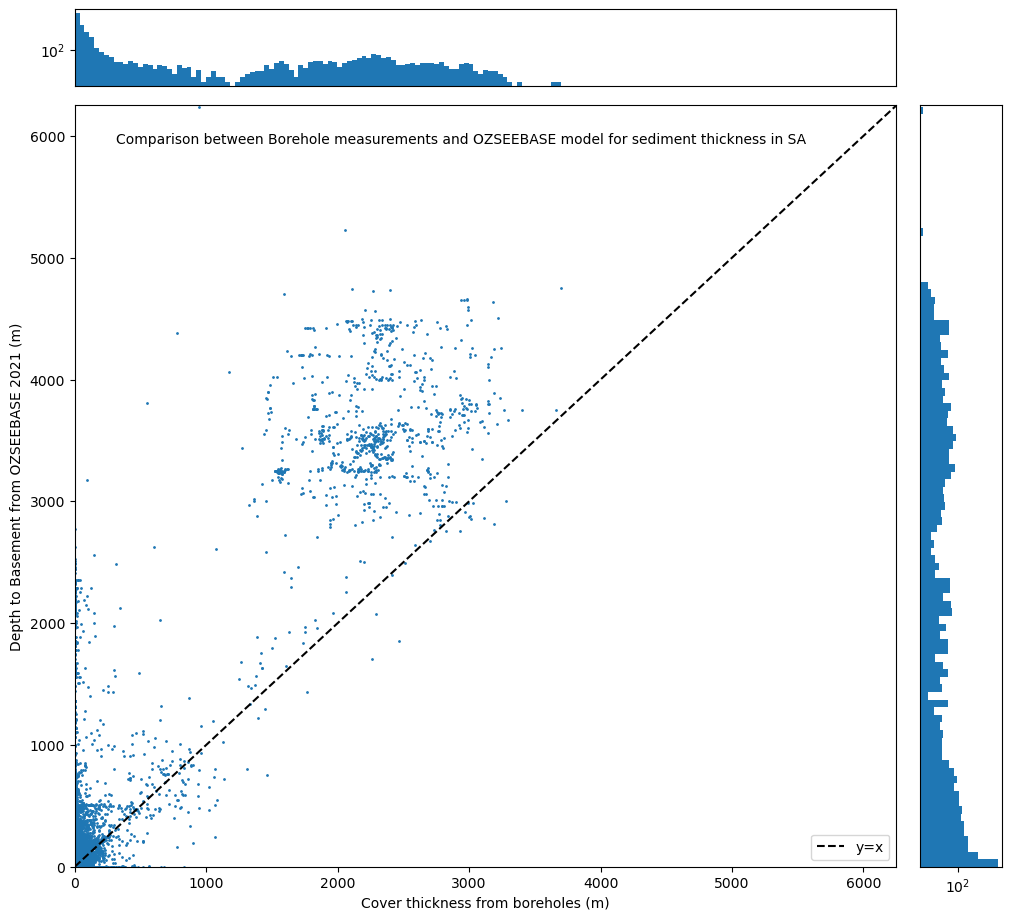

In [17]:
x = boreholes["Cover thickness (m)"]
y = boreholes["OZSEEBASE"]

x_lims = np.array([0, 6250])
y_lims = np.array([0, 6250])
fig = plt.figure(figsize=(10, 10),constrained_layout=True)
gs = fig.add_gridspec(ncols=2, nrows=3, height_ratios=[0.1, 1, 0.1], width_ratios=[1, 0.1])
joint_ax = fig.add_subplot(gs[1,0])
joint_ax.scatter(x, y, s=1)
joint_ax.plot(x_lims, y_lims, "k--", label="y=x")
joint_ax.set_xlim(x_lims)
joint_ax.set_ylim(y_lims)
joint_ax.set_xlabel("Cover thickness from boreholes (m)")
joint_ax.set_ylabel("Depth to Basement from OZSEEBASE 2021 (m)")

joint_ax.text(0.05, 0.95, "Comparison between Borehole measurements and OZSEEBASE model for sediment thickness in SA", transform=joint_ax.transAxes)
joint_ax.legend(loc="lower right")

marginal_x = fig.add_subplot(gs[0, 0])
marginal_x.hist(x, bins=100)
marginal_x.set_yscale("log")
marginal_x.set_xlim(x_lims)
marginal_x.set_xticks([], [])

marginal_y = fig.add_subplot(gs[1, 1])
marginal_y.hist(y, bins=100, orientation="horizontal")
marginal_y.set_xscale("log")
marginal_y.set_ylim(y_lims)
marginal_y.set_yticks([], [])



Text(0.5, 0.75, 'Mean Difference = 112.40')

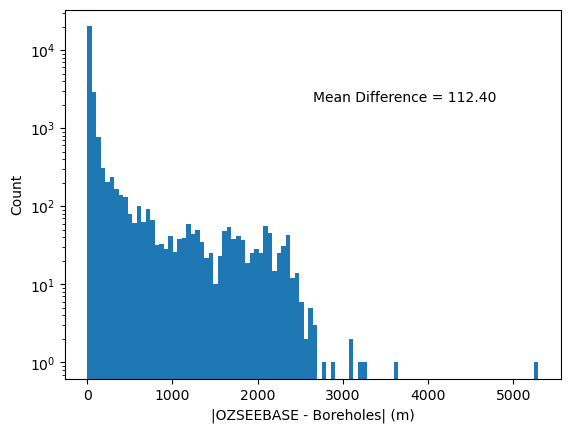

In [18]:
diff = np.abs(boreholes["OZSEEBASE"] - boreholes["Cover thickness (m)"])
ax = plt.axes()
ax.hist(diff, bins=100)
ax.set_yscale("log")
ax.set_xlabel("|OZSEEBASE - Boreholes| (m)")
ax.set_ylabel("Count")
ax.text(0.5, 0.75, f"Mean Difference = {diff.mean():.2f}", transform=ax.transAxes)

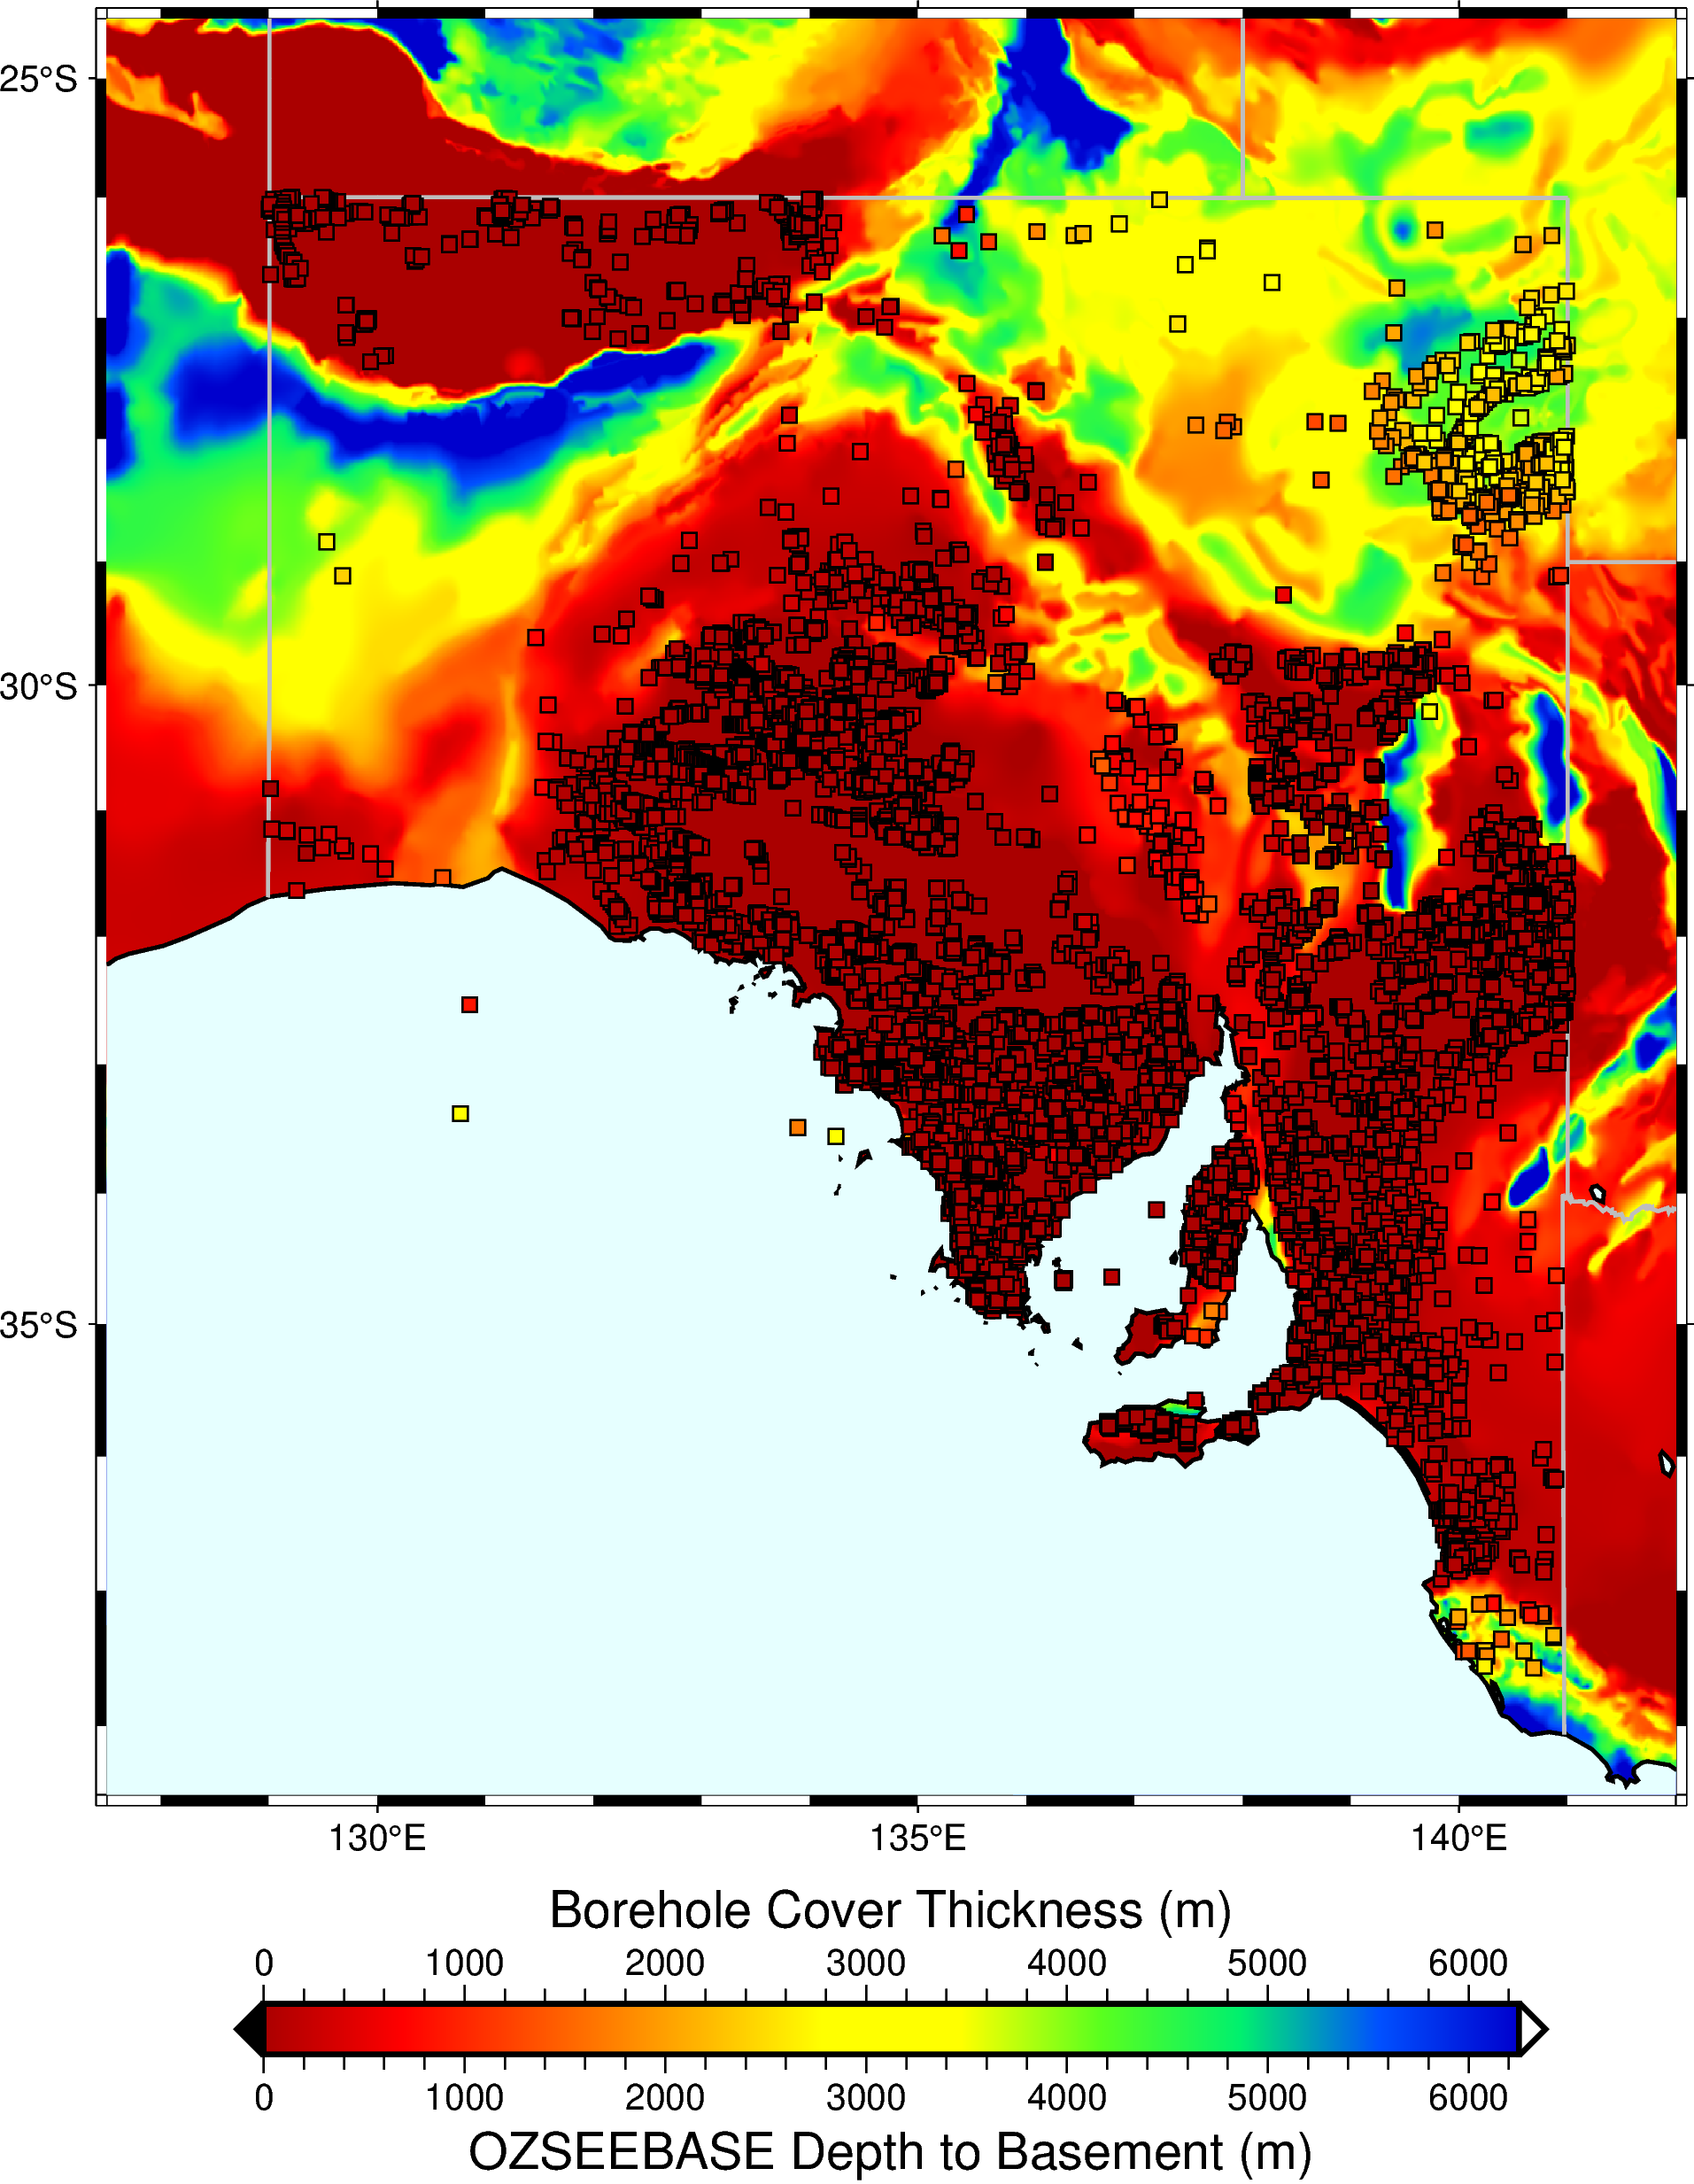

In [25]:
fig = pygmt.Figure()
fig.basemap(region=region, projection=projection, frame=True)
grid = pygmt.grdclip(grid=grid, above=(x_lims.max(), x_lims.max()), below=(x_lims.min(), x_lims.min()))
fig.grdimage(grid=grid, nan_transparent=True, cmap=cmap)
fig.coast(shorelines=1, borders="2/1p,grey", water="#e6ffff")
fig.colorbar(frame="af+lOZSEEBASE Depth to Basement (m)", position=cbar_position)
pygmt.makecpt(cmap=cmap, series=list(x_lims))
fig.plot(
    x=boreholes.x,
    y=boreholes.y,
    projection=projection,
    region=region,
    style=f"sc",
    pen="0.5p",
    fill=boreholes["Cover thickness (m)"],
    cmap=True,
    size=np.full_like(boreholes.x, 0.2),
)

fig.colorbar(frame="af+lBorehole Cover Thickness (m)", position=f"{cbar_position}+e+mal")
fig.show()